In [98]:
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt

In [183]:
# Initial conditions
n = 100 # number of trash
m = 5 # size of grid
k = 6 # number of agents
mu = [3, 2] # center of trash pile
sig = [[0.1, 0], [0, 0.1]] # spread of pile
var = 0.1 # error in measurements

T = n # number of time steps
delta = 1 # amount reward decreases per visit
xi = 2 # constant xi > 1
gamma = 3 # max message length
thresh = 0 # Maximum amount trash

messageSent = {}# dict {agent: list of messages to send - tuple [agent, time, arm, reward]}
messageRec = {}# dict {agent: list of messages received - tuple [agent, time, arm, reward]}

In [184]:
# Testing parameters

test = 100 # number of tests run
# results matrix
# row = test number = fixed trash distribution across columns
# column = degree of each agent in communication network
timestep = np.zeros((test, k))
regret = np.zeros((test, k)) # size = [test][degree][agent][time]

In [185]:
for count in range(test):
    print("Test number: {}".format(count))
    
    # Reset field
    field = np.zeros((m,m))# array of trash pieces dispersed on field
    
        
    # Initialize field
    trash = np.random.multivariate_normal(mu, sig, n)
    for i in range(n):
        x = int(trash[i][0])
        y = int(trash[i][1])
        field[x][y] += 1
    print(field)
    
    for degree in range(k):
        print("Degree: {}".format(degree))
        # Reset matrices used for calculation 
        field_temp = field.copy()
        visits = np.zeros((k,m,m))# array to track number of visits to each gridpoint
        reward = np.zeros((k,m,m))# array of sum of rewards from each gridpoint
        expected_mean = np.zeros((k,m,m)) # array of expected mean of each gridpoint
        
        # Reset Messages
        for i in range(k):
            messageSent[i] = []
            messageRec[i] = []
        
        # Initialize communication network
        graph = np.identity(k)
        if degree % 2 == 0:
            num = int(degree/2)
            for j in range(num):
                # make vertex for every (i +1) steps away
                for i in range(k):
                    neighbor = int(i + j + 1)
                    if neighbor > (k-1):
                        neighbor = neighbor - k
                    graph[i][neighbor] = 1
                    graph[neighbor][i] = 1
        else:
            num = int((degree-1)/2 + 1)
            for j in range(num):
                # make vertex for every n/2 - i steps away
                for i in range(k):
                    neighbor = int(i + k/2 - j)
                    if neighbor > (k-1):
                        neighbor = neighbor - k
                    graph[i][neighbor] = 1
                    graph[neighbor][i] = 1
                    
        # Initialize agents
        t = 0
        for i in range(k):
            for x in range(m):
                for y in range(m):
                    measure = round(np.random.normal(field_temp[x][y], var),1)
                    reward[i][x][y] += measure
                    visits[i][x][y] += 1

            # Calculate expected mean
            expected_mean[i] = np.divide(reward[i], visits[i])
        
        t += 1
        while np.max(field_temp) > thresh:
            print("t: {}".format(t))
            index = []
            for i in range(k):
                # Select arm with highest expected Q value
                Q = expected_mean[i] + var*np.divide(math.sqrt(2*(xi + 1)*math.log(t)),np.sqrt(visits[i]))
                ind = np.unravel_index(np.argmax(Q), Q.shape)
                measure = np.round(np.random.normal(field_temp[ind], var),1)
                index.append(ind)
                
                #print(ind)
                #print(Q)
                                
                # Calculate regret
                optimal_ind = np.unravel_index(np.argmax(field_temp), field_temp.shape)
                max_reward = field_temp[optimal_ind]
                actual_reward = field_temp[ind]
                regret[count][degree] += (max_reward - actual_reward)                


                # Make message to send to neighboring agents
                message = (t, i, ind, measure)
                send = messageSent[i]
                if len(send) == gamma:
                    send.pop(0)
                send.append(message)
                messageSent[i] = send

            # Pick up trash from selected grid points
            for i in range(len(index)):
                ind = index[i]
                #if field_temp[ind] > 0:
                field_temp[ind] -= 1


            # receive messages from neighbors and adjust expected mean
            for i in range(k):
                #print(i)
                new_visits= np.zeros((m,m))
                # compare new messages with history of messages and skip any repeats
                for j in range(k):
                    if graph[i][j] == 1:
                        received = messageRec[i]
                        sent = messageSent[j]
                        for l in range(len(sent)):
                            msg = sent[l]
                            if received.count(msg) == 0:
                                received.append(msg)
                                ind = msg[2]
                                visits[i][ind] += 1
                                new_visits[ind] += 1
                                reward[i][ind] += msg[3]
                        messageRec[i] = received

                # calculate expected mean
                reward[i] -= np.multiply(new_visits, visits[i])
                expected_mean[i] = np.divide(reward[i], visits[i])
                #print(reward[i])
                #print(visits[i])
                #print(expected_mean[i])           
            # Next time step
            # print(field_temp)
            t += 1
            
        timestep[count][degree] = t
    

Test number: 0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 22. 32.  0.  0.]
 [ 0. 24. 22.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Test number: 1
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 22. 23.  0.  0.]
 [ 0. 30. 25.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10

t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Test number: 10
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 21. 24.  0.  0.]
 [ 0. 31. 24.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7


t: 17
t: 18
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Test number: 20
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 27. 24.  0.  0.]
 [ 0. 22. 27.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t:

t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Test number: 29
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 20. 28.  0.  0.]
 [ 0. 23. 29.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 

t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Test number: 39
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 24. 24.  0.  0.]
 [ 0. 27. 25.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11

t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Test number: 48
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 24. 28.  0.  0.]
 [ 0. 24. 23.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 1

t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Test number: 58
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 22. 20.  0.  0.]
 [ 0. 29. 29.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11


t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Test number: 67
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 19. 23.  0.  0.]
 [ 0. 39. 19.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Test number: 68
[[ 0.

t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Test number: 77
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 23. 23.  0.  0.]
 [ 0. 27. 27.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Test number: 78
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 25. 27.  0.  0.]
 [ 0. 21. 27.  0.  0.]
 [ 0.

t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Test number: 87
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 39. 20.  0.  0.]
 [ 1. 24. 15.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5


t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
Test number: 97
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 20. 27.  0.  0.]
 [ 0. 26. 27.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 

In [186]:
print(timestep)

[[21. 20. 19. 19. 19. 20.]
 [20. 20. 19. 19. 19. 19.]
 [34. 29. 27. 23. 22. 20.]
 [19. 20. 20. 19. 18. 19.]
 [23. 21. 20. 19. 20. 20.]
 [22. 21. 21. 18. 19. 20.]
 [20. 19. 18. 19. 20. 19.]
 [21. 21. 20. 20. 20. 19.]
 [35. 31. 27. 24. 21. 20.]
 [19. 19. 19. 19. 19. 19.]
 [20. 20. 19. 18. 19. 19.]
 [23. 22. 22. 20. 20. 20.]
 [35. 29. 26. 23. 21. 20.]
 [22. 20. 20. 20. 20. 20.]
 [34. 30. 27. 24. 22. 20.]
 [22. 20. 20. 20. 19. 20.]
 [21. 22. 22. 19. 18. 19.]
 [23. 20. 21. 20. 18. 20.]
 [25. 23. 22. 19. 20. 20.]
 [19. 19. 18. 20. 19. 19.]
 [18. 19. 18. 19. 19. 19.]
 [35. 28. 27. 23. 21. 20.]
 [35. 31. 27. 23. 22. 20.]
 [34. 30. 26. 23. 22. 20.]
 [21. 20. 21. 18. 18. 19.]
 [34. 30. 28. 23. 21. 21.]
 [35. 29. 26. 23. 22. 20.]
 [19. 19. 19. 19. 19. 19.]
 [34. 30. 26. 23. 21. 20.]
 [20. 21. 19. 19. 19. 19.]
 [25. 23. 21. 20. 19. 20.]
 [18. 20. 19. 19. 19. 19.]
 [35. 30. 28. 24. 21. 20.]
 [35. 29. 26. 23. 21. 20.]
 [19. 19. 19. 18. 19. 19.]
 [21. 21. 21. 19. 20. 19.]
 [23. 22. 21. 19. 19. 20.]
 

In [187]:
avg = np.average(timestep, axis = 0)
std = np.std(timestep, axis = 0, ddof = 1)
sem = std/np.sqrt(test)
print(avg)
print(std)

[24.98 22.99 21.71 20.37 19.89 19.58]
[6.16110314 4.24619854 3.32208709 1.92093727 1.17975344 0.55377492]


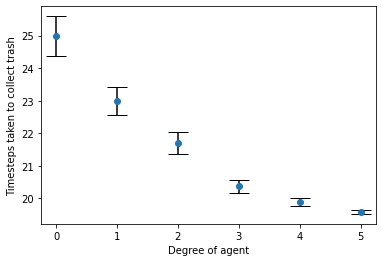

In [188]:
fig, ax = plt.subplots()
xpos = np.arange(len(avg))
ax.errorbar(xpos, avg, yerr = sem, fmt = 'o', ecolor='black', capsize=10)
ax.set_xticks(np.arange(k))
ax.set_xlabel("Degree of agent")
ax.set_ylabel("Timesteps taken to collect trash")
plt.show()

In [189]:
avg_regret = np.average(regret, axis = 0)
std_regret = np.std(regret, axis = 0, ddof = 1)
sem_regret = std_regret/np.sqrt(test)
print(avg_regret)
print(std_regret)

[774.95 376.13 212.47  93.76  23.08   0.  ]
[514.49277513 233.37353139 155.13470556  62.28788166  45.78533134
   0.        ]


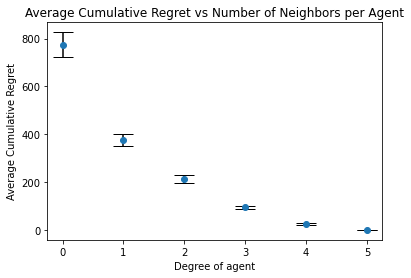

In [191]:
fig1, ax1 = plt.subplots()
xpos = np.arange(len(avg))
ax1.errorbar(xpos, avg_regret, yerr = sem_regret, fmt = 'o', ecolor='black', capsize=10)
ax1.set_xlabel("Degree of agent")
ax1.set_ylabel("Average Cumulative Regret")
ax1.set_title("Average Cumulative Regret vs Number of Neighbors per Agent")
plt.show()
fig1.save

In [174]:
print(regret)

[[338. 158. 146.  71.  28.   0.]
 [346. 192. 127.  26.   0.   0.]
 [356. 269. 132.  70.  57.   0.]
 [628. 306. 282.  87.   0.   0.]
 [614. 300. 234.  80.  23.   0.]
 [435. 219. 128.  43.  12.   0.]
 [715. 366. 126.  66.   0.   0.]
 [546. 330. 240.  74. 130.   0.]
 [352. 184. 121. 101.  35.   0.]
 [530. 252. 144. 112.   0.   0.]
 [605. 300. 170.  57.   0.   0.]
 [116. 105.  40.  39.  76.   0.]
 [612. 342. 198.  83.   0.   0.]
 [376. 201. 150.  95.  84.   0.]
 [276. 150.  66.  69.  21.   0.]
 [579. 228. 177.  18.   8.   0.]
 [765. 414. 297. 176.  49.   0.]
 [345. 134. 110.  38.   0.   0.]
 [150. 113.  97.  45.  60.   0.]
 [568. 396. 164. 176.   0.   0.]
 [171. 141. 100.   0.   0.   0.]
 [283. 138.  78.   0.   0.   0.]
 [551. 309. 180. 118.  40.   0.]
 [237. 107.  85.  10.   0.   0.]
 [220.  89. 119.  46.  30.   0.]
 [528. 216. 108. 122.  73.   0.]
 [623. 342. 198. 146.   0.   0.]
 [357. 224. 159.  87.   0.   0.]
 [300. 136.  36.  24.   0.   0.]
 [319. 143.  36.  46.   0.   0.]
 [555. 234